## import libs

In [1]:
#import dp libs
import os,sys
import zipfile
import pandas as pd
import numpy as np
import os, sys
import importlib.util
import matplotlib.pyplot as plt
%matplotlib inline
from re import search
import logging
from nltk.tokenize import RegexpTokenizer, word_tokenize, TweetTokenizer
from nltk import FreqDist
import re
import string
from nltk.corpus import stopwords
from dataclasses import dataclass



import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#data loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/ephrem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Setting static data

In [2]:
dir_=os.path.dirname(os.path.realpath("__file__"))
path=dir_
logger=logging.basicConfig(level=logging.INFO)
SAVE_FILE = False

In [3]:
@dataclass
class folders:

    dataset_path: str = f'{path}/fake_news_dataset/'
    archive_name:str='archive.zip'
    clean_dataset_name:str ='fake_news_dataset.csv'
    preprocessed_dataset_name:str='fake_news_preprocessed.csv'
    fake_data:str='Fake.csv'
    true_data:str='True.csv'
    kaggle_dataset_location:str='clmentbisaillon/fake-and-real-news-dataset/'

In [4]:
def get_dataset(dpth, url, archive_name,SAVE_FILE = False):
    '''
    Amethod used to fetch dataset from Kaggle and store in a working direcory 
    '''
    if not os.path.exists(dpth):
        try: 
            os.mkdir(dpth)
        except FileExistsError as e:
            logger.exception(e)
        pass
    if not os.path.exists(dpth + archive_name):
        !kaggle datasets download -d $url -p $dpth
    if not os.path.exists(dpth + folders.fake_data):
        with zipfile.ZipFile(dpth + archive_name, 'r') as zip_ref:
            zip_ref.extractall(path=dpth)
            
def load_dataset(dpth, fpth,tpth):
    '''
    read dataset from workspace
    
    
    Return:
        merged dataset as dataframe
    
    '''
    try:
        if os.path.exists(dpth):
            fake_df=pd.read_csv(dpth+fpth)
            true_df=pd.read_csv(dpth+tpth)
            true_df['label'] = 'true'
            fake_df['label'] = 'fake'
            merged_df = pd.concat([fake_df, true_df], ignore_index=True)
        return merged_df
    except Exception as e:
        print(e)
def clean_dataset(df,target_col):
    '''
    Check for placeholder values and duplicates
    removing completely duplicate rows througout, rows with only ttitles, rows with empty text
    
    Return:
        cleaned dataframe dataset
    '''
    #dupliate_col_length=len(df[df[target_col]].value_counts())
    #print(dupliate_col_length)
    #empty text rows
    df_text_empty=len(df[df.text == ' '])
    print(df_text_empty)
    #replace whitespace with Nan
    df = df.replace(r'^\s*$', np.nan, regex=True)
    df_clean = df.drop_duplicates(ignore_index=True)
    #Drop Rows with No Text (just a title)
    df_clean = df_clean.dropna()
    #Drop Rows with same title and text 
    df_clean = df_clean.drop_duplicates(['title', 'text'], ignore_index=True)
    #Drop Rows with the same text 
    df_clean = df_clean.drop_duplicates(['text'], ignore_index=True) 
    def not_a_date(string):
        """
        Check if the input string can be converted to a date.

        Return:
            True if it is not a date
            False if it is a date
        """
        try:
            date = pd.to_datetime(string)
            return False
        except ValueError:
            return True
    
    df_bad_dates = df_clean[df_clean['date'].apply(not_a_date)]
    df_clean = df_clean.drop(df_bad_dates.index)
    df_clean['date'] = pd.to_datetime(df_clean['date']) 
    df_clean['title_len'] = df_clean.title.apply(len)
    df_clean['text_len'] = df_clean.text.apply(len)
    df_clean['caps_in_title'] = df_clean['title'].apply(lambda title: sum(1 for char in title if char.isupper()))
    df_clean['norm_caps_in_title'] = df_clean['caps_in_title'] / df_clean['title_len']
    df_clean['caps_in_text'] = df_clean['text'].apply(lambda text: sum(1 for char in text if char.isupper()))
    df_clean['norm_caps_in_text'] = df_clean['caps_in_text'] / df_clean['text_len']
    if SAVE_FILE:
        df_clean.to_csv(folders.dataset_path + folders.clean_dataset, index=False)
    return df_clean
    
def mentioned_keywords_text(df):
    def check_string_for(substring, fullstring):
        """Check if the substring is in the fullstring"""
        if search(substring, fullstring):
            return True
        else:
            return False
    '''
    e.g. how many of the stories/texts contain the string Reuters?
    
    '''
    df_reuters = df[df.text.apply(lambda news_text: check_string_for('Reuters', news_text))]
    mentioned_df=df_reuters.label.value_counts()
    
    return mentioned_df

    
def plot_cols_distribution(df, column, title):
    """
    Display a histogram for a column in a cleaned dataframe, splitting the data by label.
    
    """
    plt.figure(figsize=(16,8))
    df[df.label == 'true'][column].hist(label='True')
    df[df.label == 'fake'][column].hist(alpha=0.4, label='Fake')
    plt.title(title)
    plt.legend()
    plt.show()

In [5]:
print('==============================================')
print('downlaod the fake news dataset and store in a working directory ')
get_dataset(folders.dataset_path,folders.kaggle_dataset_location,folders.archive_name,SAVE_FILE=False)
os.listdir(folders.dataset_path)
print('===============================================')


downlaod the fake news dataset and store in a working directory 


In [6]:
print('==============================================')
print('load dataset and merge as single dataframe ')
merged_df = load_dataset(folders.dataset_path,folders.fake_data,folders.true_data,)
merged_df.info(verbose=True)
print('===============================================')


load dataset and merge as single dataframe 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [7]:
print('==============================================')
print('cleaned final fakenews dataset')
df_clean = clean_dataset(merged_df,'title')
df_clean.to_csv(folders.dataset_path + folders.clean_dataset_name, index=False)
df_clean.info(verbose=True)
print('===============================================')


cleaned final fakenews dataset
627
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38638 entries, 0 to 38643
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   title               38638 non-null  object        
 1   text                38638 non-null  object        
 2   subject             38638 non-null  object        
 3   date                38638 non-null  datetime64[ns]
 4   label               38638 non-null  object        
 5   title_len           38638 non-null  int64         
 6   text_len            38638 non-null  int64         
 7   caps_in_title       38638 non-null  int64         
 8   norm_caps_in_title  38638 non-null  float64       
 9   caps_in_text        38638 non-null  int64         
 10  norm_caps_in_text   38638 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 3.5+ MB


# As part of exploration - distribution of few columns 


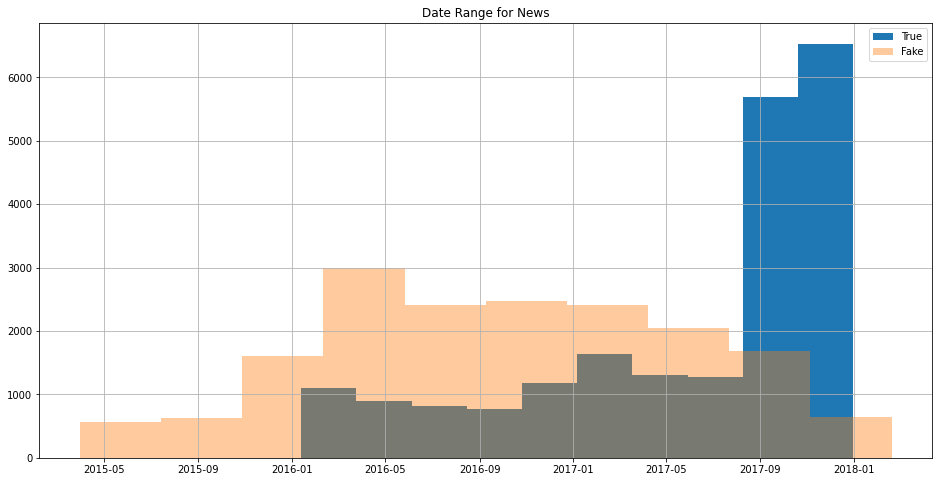

In [8]:
plot_cols_distribution(df_clean, 'date', 'Date Range for News')

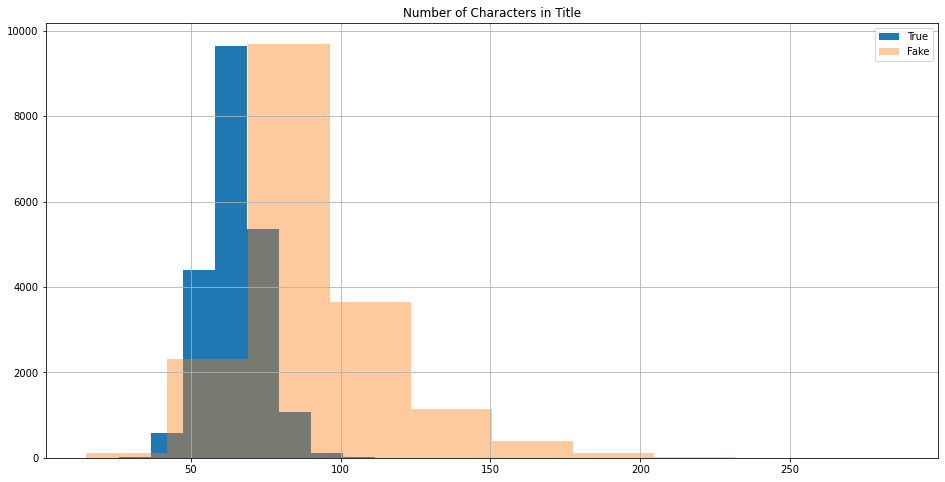

In [9]:
df_clean['title_len'] = df_clean.title.apply(len)
plot_cols_distribution(df_clean, 'title_len', 'Number of Characters in Title')


In [10]:
#df=mentioned_keywords_text(df_clean)
#df

# Preprocessing pipeline 

In [11]:
class PreprocessingUtilitty():
    def __init__(self):
        pass
    def concat_lists_of_strings(slef, df, column):
        """Concatenate a series of lists of strings from a column in a dataframe"""
        return [x for list_ in df[column].values for x in list_]
    def find_strings(self, string_, regex):
        """Find and Return a list of URLs in the input string"""
        list_ = re.findall(regex, string_)
        return [s[0] for s in list_]
    def freq_dist_of_col(self, df, col):
        """Return a Frequency Distribution of a column"""
        corpus_tokens = concat_lists_of_strings(df, col)
        corpus_freq_dist = FreqDist(corpus_tokens)
        print(f'The number of unique tokens in the corpus is {len(corpus_freq_dist)}')
        return corpus_freq_dist
    def review_freq_dis(self, df, col, n):
        """
        Create a Frequency Distribution of a column of a dataframe and display
        the n most common tokens.
        """
        corpus_freq_dist = freq_dist_of_col(df, col)
        display(corpus_freq_dist.most_common(n))
    def remove_punctuation(self,word_list, punctuation_list):
        """Remove punctuation tokens from a list of tokens"""
        return [w for w in word_list if w not in punctuation_list]
    def remove_single_characters(self, word_list, exception_list):
        """Remove all the single characters, except those on the exception list"""
        return [w for w in word_list if (len(w) > 1 or w in exception_list)]
    def remove_words(self, word_list, words_to_remove):
        """Remove all the words in the words_to_remove list from the words_list"""
        return [w for w in word_list if w not in words_to_remove]
    def lower_unless_all_caps(self, string_):
        """
        Make all words in the input string lowercase unless that 
        word is in all caps
        """
        words = string_.split()
        processed_words = [w.lower() if not (w.isupper() and len(w) > 1) else w for w in words]
        return ' '.join(processed_words)

helper=PreprocessingUtilitty()


def filter_urls(df):
    
    '''
    A method that filters urls, twitter handles and lowercases words 
    
    Return:
        cleaned dataframe 
    
    '''
    URL_REGEX = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    df['text_urls'] = df['text'].apply(lambda x: helper.find_strings(x, URL_REGEX))
    #mapping urls into a string which is at least conveys some meaning 
    df['clean_text'] = df['text'].apply(lambda x: re.sub(URL_REGEX, '{link}', x))
    #cheking urls in titles 
    df['title_urls'] = df['title'].apply(lambda x: helper.find_strings(x, URL_REGEX))

    #checking if there are twitter handles 
    TWITTER_HANDLE_REGEX = r'(?<=^|(?<=[^\w]))(@\w{1,15})\b'
    df['twitter_handles']=df['clean_text'].apply(lambda x: re.findall(TWITTER_HANDLE_REGEX,x))
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(TWITTER_HANDLE_REGEX, '@twitter-handle', x))
    #lowercase the words except all caps case
    df['clean_title'] = df['title'].apply(helper.lower_unless_all_caps)
    
    return df


def apply_cleansing(df):
    
    '''
    A method that tokenizes and cleans single chars, s', and words 
    
    Return:
          cleaned dataframe
    '''
    #remove irrelevant numeric figures
    
    df['clean_title'] = df['clean_title'].apply(lambda x: re.sub(r'9\/11', 'nine-eleven', x))
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'9\/11', 'nine-eleven', x))
    df['clean_title'] = df['clean_title'].apply(lambda x: re.sub(r'\d+', ' ', x))
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'\d+', ' ', x))
    
    #tokenize
    df['clean_title_tokens'] =df['clean_title'].apply(word_tokenize)
    df['clean_text_tokens'] = df['clean_text'].apply(word_tokenize)
    #remove the word reuters to avoid repetetive 
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'\(reuters\)', ' ', x))
    #remove single letter and chars from title and text cols becaus
    df['clean_text_tokens'] = df['clean_text_tokens'].apply(lambda x: helper.remove_single_characters(x, ['i', '!']))
    df['clean_title_tokens'] = df['clean_title_tokens'].apply(lambda x: helper.remove_single_characters(x, ['i', '!']))
    
    #remove s'                                         
    df['clean_text_tokens'] = df['clean_text_tokens'].apply(lambda x: helper.remove_words(x, ["'s"]))
    df['clean_title_tokens'] = df['clean_title_tokens'].apply(lambda x: helper.remove_words(x, ["'s"]))
    
    #remove date words inside clean text and titles
    date_words = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 
                  'saturday', 'sunday', 'january', 'february', 'march', 'april',
                 'may', 'june', 'july', 'august', 'september', 'october',
                 'november', 'december']
    df['clean_text_tokens'] = df['clean_text_tokens'].apply(lambda x: helper.remove_words(x, date_words))
    df['clean_title_tokens'] = df['clean_title_tokens'].apply(lambda x: helper.remove_words(x, date_words))
    
    if SAVE_FILE:
        df.to_csv(DATASET_PATH + PREPROCESSED_DATASET_NAME, index=False)
    
    
    return df
    

In [12]:
print('=================================')
print('test filter methed goes here to filter urls and twitter handles ')
df = pd.read_csv(folders.dataset_path + folders.clean_dataset_name)

df_filter=filter_urls(df)
df_filter.info()

test filter methed goes here to filter urls and twitter handles 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38638 entries, 0 to 38637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               38638 non-null  object 
 1   text                38638 non-null  object 
 2   subject             38638 non-null  object 
 3   date                38638 non-null  object 
 4   label               38638 non-null  object 
 5   title_len           38638 non-null  int64  
 6   text_len            38638 non-null  int64  
 7   caps_in_title       38638 non-null  int64  
 8   norm_caps_in_title  38638 non-null  float64
 9   caps_in_text        38638 non-null  int64  
 10  norm_caps_in_text   38638 non-null  float64
 11  text_urls           38638 non-null  object 
 12  clean_text          38638 non-null  object 
 13  title_urls          38638 non-null  object 
 14  twitter_handles     38638 non-null  o

In [13]:
df_clean=apply_cleansing(df_filter)
df_clean

,title,text,subject,date,label,title_len,text_len,caps_in_title,norm_caps_in_title,caps_in_text,norm_caps_in_text,text_urls,clean_text,title_urls,twitter_handles,clean_title,clean_title_tokens,clean_text_tokens
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake,79,2893,11,0.139241,138,0.047701,[pic.twitter.com/4FPAe2KypA],Donald Trump just couldn t wish all Americans ...,[],"[@realDonaldTrump, @TalbertSwan, @calvinstowel...",donald trump sends out embarrassing new year’s...,"[donald, trump, sends, out, embarrassing, new,...","[Donald, Trump, just, couldn, wish, all, Ameri..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake,69,1898,8,0.115942,88,0.046365,[],House Intelligence Committee Chairman Devin Nu...,[],[],drunk bragging trump staffer started russian c...,"[drunk, bragging, trump, staffer, started, rus...","[House, Intelligence, Committee, Chairman, Dev..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake,90,3597,15,0.166667,308,0.085627,"[pic.twitter.com/XtZW5PdU2b, pic.twitter.com/T...","On Friday, it was revealed that former Milwauk...",[],"[@SheriffClarke, @SheriffClarke, @KeithLeBlanc...",sheriff david clarke becomes an internet joke ...,"[sheriff, david, clarke, becomes, an, internet...","[On, Friday, it, was, revealed, that, former, ..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake,78,2774,19,0.243590,123,0.044340,"[https://t.co/Fg7VacxRtJ, pic.twitter.com/5gEM...","On Christmas day, Donald Trump announced that ...",[],"[@pbump, @_cingraham, @_cingraham, @_cingraham...",trump is so obsessed he even has obama’s name ...,"[trump, is, so, obsessed, he, even, has, obama...","[On, Christmas, day, Donald, Trump, announced,..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake,70,2346,11,0.157143,63,0.026854,[],Pope Francis used his annual Christmas Day mes...,[],[],pope francis just called out donald trump duri...,"[pope, francis, just, called, out, donald, tru...","[Pope, Francis, used, his, annual, Christmas, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38633,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22,true,61,2821,8,0.131148,116,0.041120,[],BRUSSELS (Reuters) - NATO allies on Tuesday we...,[],[],'fully committed' NATO backs new U.S. approach...,"['fully, committed, NATO, backs, new, U.S., ap...","[BRUSSELS, Reuters, NATO, allies, on, Tuesday,..."
38634,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,true,52,800,3,0.057692,39,0.048750,[],"LONDON (Reuters) - LexisNexis, a provider of l...",[],[],lexisnexis withdrew two products from chinese ...,"[lexisnexis, withdrew, two, products, from, ch...","[LONDON, Reuters, LexisNexis, provider, of, le..."
38635,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,true,49,1950,1,0.020408,54,0.027692,[],MINSK (Reuters) - In the shadow of disused Sov...,[],[],minsk cultural hub becomes haven from authorities,"[minsk, cultural, hub, becomes, haven, from, a...","[MINSK, Reuters, In, the, shadow, of, disused,..."
38636,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,true,61,1199,4,0.065574,55,0.045872,[],MOSCOW (Reuters) - Vatican Secretary of State ...,[],[],vatican upbeat on possibility of pope francis ...,"[vatican, upbeat, on, possibility, of, pope, f...","[MOSCOW, Reuters, Vatican, Secretary, of, Stat..."


In [14]:
df_clean['label'].value_counts()

true    21191
fake    17447
Name: label, dtype: int64

In [15]:
def split_train_test(df_clean, verbose=False):
    df_clean['merged_text']=df_clean['title']+df_clean['text']
    df_clean['target_label']=df_clean['label'].map({'fake':1, 'true':0})
    df_clean_clean_train=pd.DataFrame()
    df_clean_clean_train['merged_text']=df_clean['merged_text']
    df_clean_clean_train['target_label']=df_clean['target_label']   
    #df_clean_clean_train['target_label'].value_counts()
    X=df_clean_clean_train['merged_text']
    y=df_clean_clean_train['target_label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 20)
   
    return X_train,X_test,y_train,y_test
    


In [16]:
X_train, X_test, y_train, y_test =split_train_test(df_clean)
y_train.size

30910

In [17]:
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(X_test, y_test, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=y_test)
val_labels.size

3864

# Modeling pipeline

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text(0, 0.5, 'Number of texts')

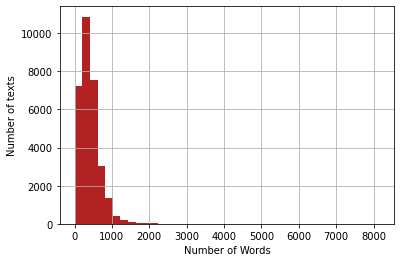

In [18]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in X_train]
pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [19]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())
# Data Loader structure definition
batch_size = 32                                               #define a batch size
train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

/home/ephrem/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [20]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [21]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x
model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 2

/home/ephrem/anaconda3/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [22]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(val_dataloader):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [23]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    966.
  Batch   100  of    966.
  Batch   150  of    966.
  Batch   200  of    966.
  Batch   250  of    966.
  Batch   300  of    966.
  Batch   350  of    966.
  Batch   400  of    966.
  Batch   450  of    966.
  Batch   500  of    966.
  Batch   550  of    966.
  Batch   600  of    966.
  Batch   650  of    966.
  Batch   700  of    966.
  Batch   750  of    966.
  Batch   800  of    966.
  Batch   850  of    966.
  Batch   900  of    966.
  Batch   950  of    966.

Evaluating...
  Batch    50  of    121.
  Batch   100  of    121.

Training Loss: 0.572
Validation Loss: 0.508

 Epoch 2 / 2
  Batch    50  of    966.
  Batch   100  of    966.
  Batch   150  of    966.
  Batch   200  of    966.
  Batch   250  of    966.
  Batch   300  of    966.
  Batch   350  of    966.
  Batch   400  of    966.
  Batch   450  of    966.
  Batch   500  of    966.
  Batch   550  of    966.
  Batch   600  of    966.
  Batch   650  of    966.
  Batch   700  of    966.
  

In [24]:
# load weights of best model
def get_classification_report(pth):
    model.load_state_dict(torch.load(pth))
    with torch.no_grad():
      preds = model(test_seq, test_mask)
      preds = preds.detach().cpu().numpy()

    preds = np.argmax(preds, axis = 1)
    #print(classification_report(test_y, preds))
    return classification_report(test_y, preds)

In [27]:
path = 'c2_new_model_weights.pt'
print(get_classification_report(path))

              precision    recall  f1-score   support

           0       0.77      0.96      0.85      2119
           1       0.93      0.64      0.76      1745

    accuracy                           0.82      3864
   macro avg       0.85      0.80      0.81      3864
weighted avg       0.84      0.82      0.81      3864

